## Generative Adversarial Networks (GAN)
For this project, I will be designing and training a GAN for image generation.

Training a GAN for image generation can be computationally demanding. Luckily, MNIST dataset provides 28x28 images of handwritten digits, allowing a GAN to be trained more quickly. Below are some examples from the digits dataset:

## What is a GAN?

A GAN is a deep-learning-based generative model to create synthetic images, videos, music, and text with a real dataset. A GAN operates in the following steps in case of generating images:
1. The generator takes in random numbers and returns an image.
2. This generated image is fed into the discriminator with images taken from the ground-truth dataset.
3. The discriminator takes in both real and fake images and returns probabilities.
4. In a train process, the generator tries to generate synthetic images to deceive the discriminator while the discriminator tries to predict whether the image is real or fake.

100%|██████████| 9912422/9912422 [00:00<00:00, 188030949.36it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41202616.95it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 84601164.53it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22518355.52it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



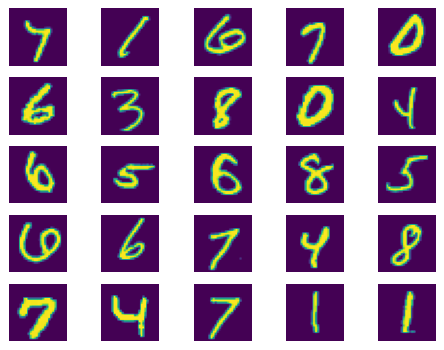

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

mnist = MNIST(root='.', download=True)
images = np.stack([data[0] for data in mnist]).astype(np.float32)
images = images / 128 - 1    # normalize between -1 and 1
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[np.random.choice(len(images))])
    plt.axis('off')
plt.show()

### 2.1 Generator and Discriminator
In this part, I am implementing a generator and discriminator model. Here,
* A **generator** takes a randomly sampled noise $z$ as input and outputs an image with the same size as the dataset
* A **discriminator** takes an image as input and performs a binary classification

In this case, both the generator and discriminator are convolutional neural networks (CNNs).

In [219]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(1, 16, 5, 1, 1)
        # self.conv2 = nn.Conv2d(16, 32, 5, 1, 1)
        # self.conv3 = nn.Conv2d(32, 64, 5, 1, 1)
        # self.conv4 = nn.Conv2d(64, 128, 5, 1, 1)
        # self.flatten = nn.Flatten()
        # self.linear = nn.Linear(51200, 1)

        self.linear1 = nn.Linear(28 * 28, 16 * 16)
        self.linear2 = nn.Linear(16 * 16, 16 * 16)
        self.linear3 = nn.Linear(16 * 16, 1)

    def forward(self, x):
        # x = self.conv1(x)
        # x = F.relu(x)
        # x = self.conv2(x)
        # x = F.relu(x)
        # x = self.conv3(x)
        # x = F.relu(x)
        # x = self.conv4(x)
        # x = F.relu(x)
        # x = self.flatten(x)
        # x = self.linear(x)
        # output = F.sigmoid(x)

        x = self.linear1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.linear2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.linear3(x)
        output = F.sigmoid(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.linear = nn.Linear(100, 128 * 20 * 20)
        # self.convTrans1 = nn.ConvTranspose2d(128, 64, 5, 1, 1)
        # self.convTrans2 = nn.ConvTranspose2d(64, 32, 5, 1, 1)
        # self.convTrans3 = nn.ConvTranspose2d(32, 16, 5, 1, 1)
        # self.convTrans4 = nn.ConvTranspose2d(16, 1, 5, 1, 1)

        self.linear1 = nn.Linear(100, 16 * 16)
        self.linear2 = nn.Linear(16 * 16, 16 * 16)
        self.linear3 = nn.Linear(16 * 16, 28 * 28)

    def forward(self, x):
        # x = self.linear(x)
        # x = F.relu(x)
        # x = torch.reshape(x, (x.size(0), 128, 20, 20))
        # x = self.convTrans1(x)
        # x = F.relu(x)
        # x = self.convTrans2(x)
        # x = F.relu(x)
        # x = self.convTrans3(x)
        # x = F.relu(x)
        # x = self.convTrans4(x)
        # output = F.tanh(x)

        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.tanh(x)
        output = torch.reshape(x, (x.size(0), 1, 28, 28))
        return output

gen = Generator()
disc = Discriminator()
if torch.cuda.is_available:
    gen = gen.cuda()
    disc = disc.cuda()

### 2.2 Generate image samples from generator

During the training and inference, the generator needs to generate batch of images from random noise. The following section will be conducting the explained task.

In [220]:
def generate_samples(model, num_samples):
    # The shape of the returned samples should be [num_samples, H, W]
    noise = 100
    samples = torch.randn(num_samples, noise)
    if torch.cuda.is_available:
      samples = samples.cuda()

    return model(samples)

Without any training, the samples generated by the generator do not resemble any digit in the dataset.

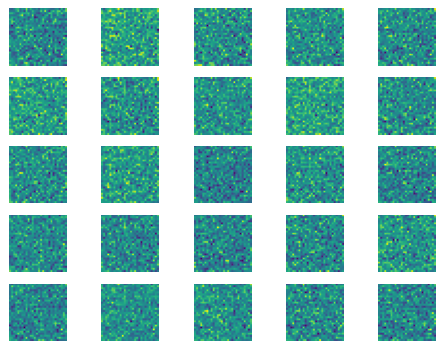

In [221]:
gen.eval()
samples = generate_samples(gen, 25).squeeze().detach().cpu().numpy()
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.show()

### 2.3 GAN training algorithm
In this section, I am implementing the GAN training algorithm, which involves alternating the training of discriminator and generator.

**Note:** The standard GAN algorithm and loss functions are provided in this paper: Goodfellow, Ian, et al. "Generative adversarial networks." Communications of the ACM 63.11 (2020): 139-144.(https://arxiv.org/abs/1406.2661)

In [222]:
def train_gan(gen, disc, images, num_epochs, batch_size):
    from tqdm.autonotebook import tqdm
    from torch.utils.data import DataLoader

    losses_gen = []
    losses_disc = []

    gen.train()
    disc.train()
    loader = DataLoader(images, batch_size=batch_size, shuffle=True)

    # 1. Building an optimizer for each model and choosing an appropriate learning rate
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=0.0002)
    optimizer_disc = torch.optim.Adam(disc.parameters(), lr=0.0002)

    pbar = tqdm(range(num_epochs))
    for e in pbar:
        for i, data_real in enumerate(loader):
            if torch.cuda.is_available:
                data_real = data_real.cuda()

            # 2. Update discriminator
            # 2.1. Unfreeze discriminator
            disc.train()
            disc.requires_grad_(True)

            # 2.2. Constructing inputs and training labels for discriminator
            #      The discriminator training uses both real and fake samples
            data_real = data_real.reshape(data_real.size(0), 1, 28, 28)
            data_fake = generate_samples(gen, batch_size).detach().clone()
            labels_real = torch.ones(batch_size, 1).cuda()
            labels_fake = torch.zeros(batch_size, 1).cuda()
            inputs_disc = torch.cat((data_real, data_fake), dim=0)
            inputs_disc = inputs_disc.reshape(2 * batch_size, -1)
            labels_disc = torch.cat((labels_real, labels_fake), dim=0)

            if torch.cuda.is_available:
                inputs_disc = inputs_disc.cuda()
                labels_disc = labels_disc.cuda()

            # 2.4. Discrminator training
            #      Includes loss computation and weight updates
            outputs_disc = disc(inputs_disc)
            loss_disc = nn.BCELoss()(outputs_disc, labels_disc)
            losses_disc.append(loss_disc.item())
            optimizer_disc.zero_grad()
            loss_disc.backward()
            optimizer_disc.step()

            # 3. Update generator
            # 3.1. Freeze discriminator
            disc.eval()
            disc.requires_grad_(False)

            # 3.2. Constructing input and training labels for the generator
            #      The generator training only uses fake samples, since in this step
            #      only the generator will be updated.
            inputs_gen = generate_samples(gen, batch_size)
            inputs_gen = inputs_gen.reshape(batch_size, -1)
            labels_gen = torch.ones(batch_size, 1).cuda()
            if torch.cuda.is_available:
                inputs_gen = inputs_gen.cuda()
                labels_gen = labels_gen.cuda()

            # 3.4. Generator training
            #      Includes loss computation and weight updates
            outputs_gen = disc(inputs_gen)
            loss_gen = nn.BCELoss()(outputs_gen, labels_gen)
            losses_gen.append(loss_gen.item())
            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()

            pbar.set_postfix(loss_gen=losses_gen[-1], loss_disc=losses_disc[-1])
    return losses_gen, losses_disc

You may change the number of epochs and batch size based on the time and resources available to you.

In [223]:
num_epochs = 500
batch_size = 100
losses_gen, losses_disc = train_gan(gen, disc, images, num_epochs=num_epochs, batch_size=batch_size)

  0%|          | 0/500 [00:00<?, ?it/s]

### 2.4 Observations and Analysis

There is clearly no problem with the training process since the plot for the losses of the generator and discriminator converges, or at the very least, seems to converge at around 1. Here, the generator is mostly successful in confusing the discriminator by producing false images, and as a result, the loss for the discriminator approaches the loss of the generator.

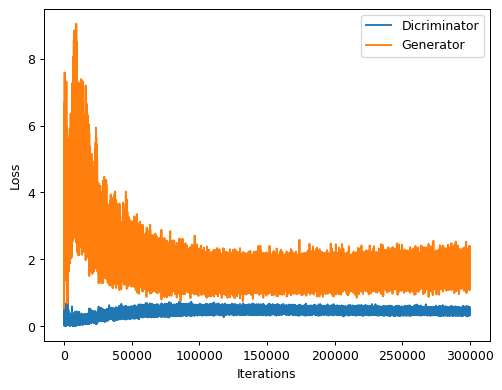

In [224]:
plt.figure(dpi=90)
plt.plot(losses_disc, label='Dicriminator')
plt.plot(losses_gen, label='Generator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see the results below:

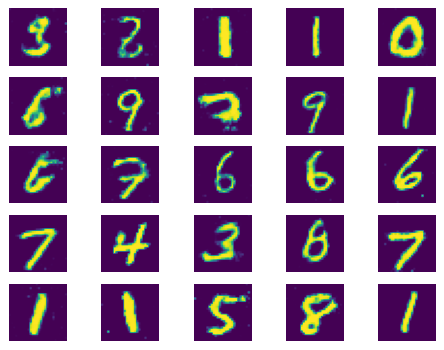

In [225]:
gen.eval()
samples = generate_samples(gen, 25).squeeze().detach().cpu().numpy()
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.show()